In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

# Multi-Agent Research System

This notebook combines all the previous components into a single system.

Here is our overall research flow:

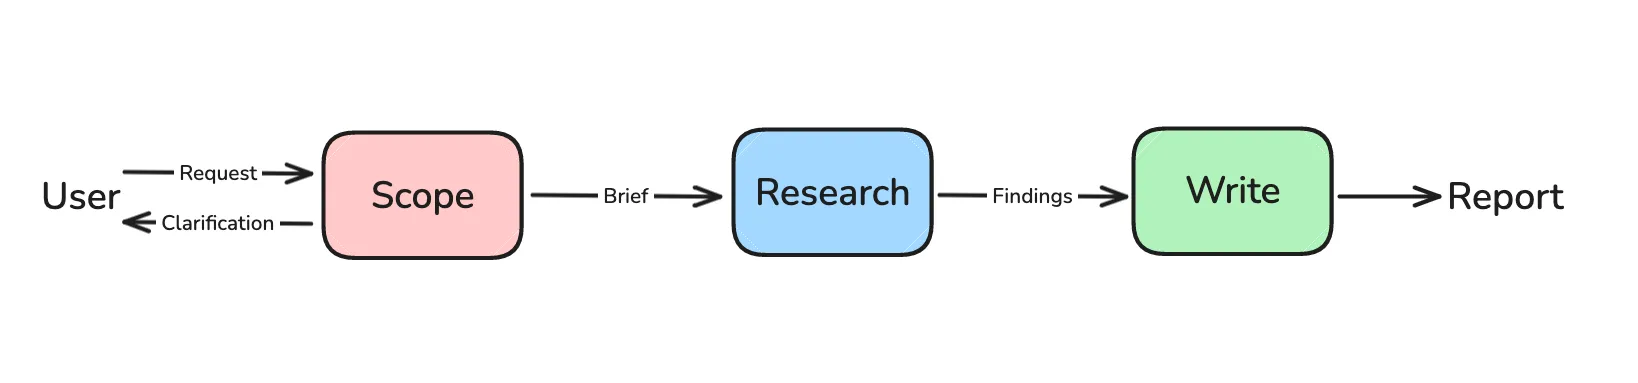

We've built research scoping and multi-agent research in previous notebooks.

Now, we'll add the final report generation step.

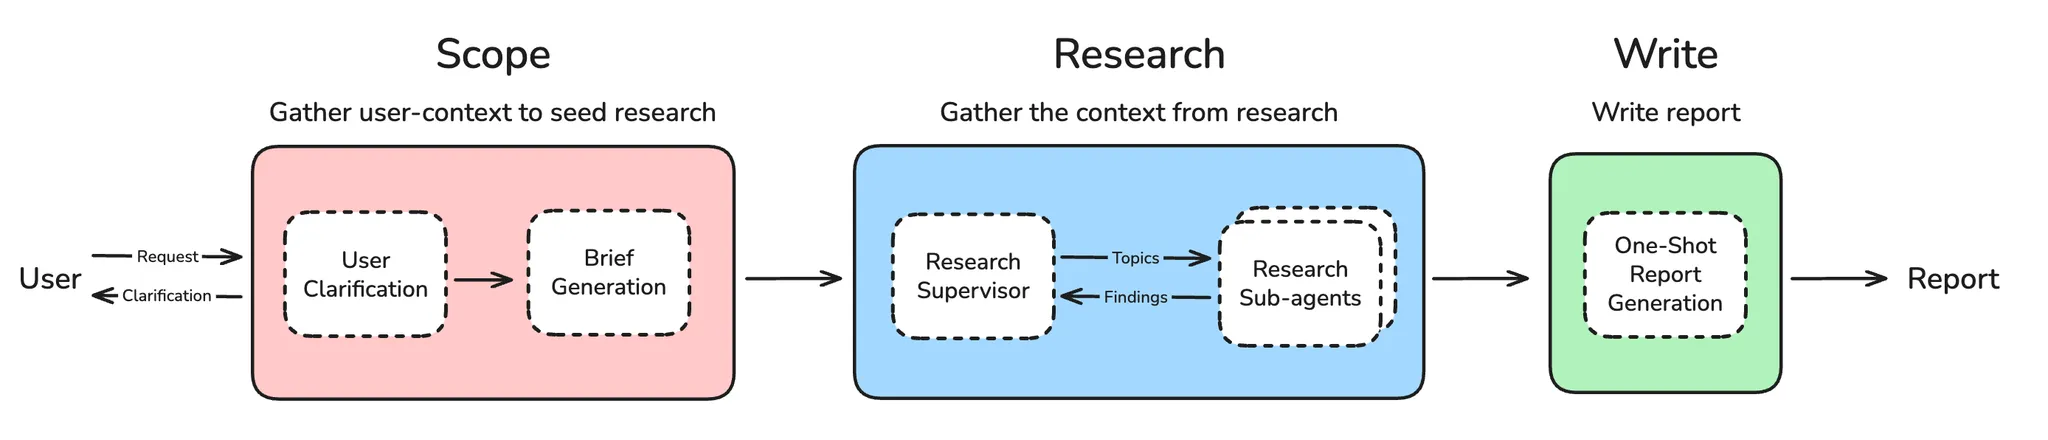

### Agent 

We simply can re-use the components we've already built.

In [2]:
%%writefile ../src/deep_research_from_scratch/research_agent_full.py

"""
Full Multi-Agent Research System

This module integrates all components of the research system:
- User clarification and scoping
- Research brief generation  
- Multi-agent research coordination
- Final report generation

The system orchestrates the complete research workflow from initial user
input through final report delivery.
"""

from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END

from deep_research_from_scratch.utils import get_today_str
from deep_research_from_scratch.prompts import final_report_generation_prompt
from deep_research_from_scratch.state_scope import AgentState, AgentInputState
from deep_research_from_scratch.research_agent_scope import clarify_with_user, write_research_brief
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent

# ===== Config =====

from langchain.chat_models import init_chat_model
writer_model = init_chat_model(model="openai:gpt-4.1", max_tokens=32000) # model="anthropic:claude-sonnet-4-20250514", max_tokens=64000

# ===== FINAL REPORT GENERATION =====

from deep_research_from_scratch.state_scope import AgentState

async def final_report_generation(state: AgentState):
    """
    Final report generation node.
    
    Synthesizes all research findings into a comprehensive final report
    """
    
    notes = state.get("notes", [])
    
    findings = "\n".join(notes)

    final_report_prompt = final_report_generation_prompt.format(
        research_brief=state.get("research_brief", ""),
        findings=findings,
        date=get_today_str()
    )
    
    final_report = await writer_model.ainvoke([HumanMessage(content=final_report_prompt)])
    
    return {
        "final_report": final_report.content, 
        "messages": ["Here is the final report: " + final_report.content],
    }

# ===== GRAPH CONSTRUCTION =====
# Build the overall workflow
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add workflow nodes
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)
deep_researcher_builder.add_node("supervisor_subgraph", supervisor_agent)
deep_researcher_builder.add_node("final_report_generation", final_report_generation)

# Add workflow edges
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", "supervisor_subgraph")
deep_researcher_builder.add_edge("supervisor_subgraph", "final_report_generation")
deep_researcher_builder.add_edge("final_report_generation", END)

# Compile the full workflow
agent = deep_researcher_builder.compile()

Overwriting ../src/deep_research_from_scratch/research_agent_full.py


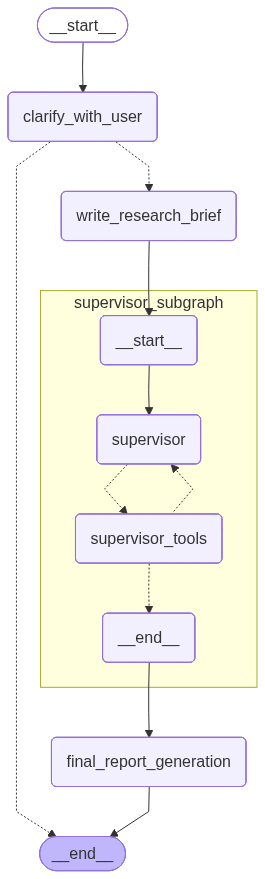

In [3]:
# Run the workflow
from utils import format_messages
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research_from_scratch.research_agent_full import deep_researcher_builder

checkpointer = InMemorySaver()
full_agent = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(full_agent.get_graph(xray=True).draw_mermaid_png()))

LangGraph has a default recursion limit of 25 steps to prevent infinite loops. For complex research workflows that require iterative rounds of research, this limit needs to be increased. As explained in [LangGraph's troubleshooting guide](https://langchain-ai.github.io/langgraph/troubleshooting/errors/GRAPH_RECURSION_LIMIT/), the recursion limit counts every node execution in the graph. In our multi-agent research system:

- **Single Research Agent**: May take 8-12 steps for tool calls and compression
- **Multi-Agent Supervisor**: Each sub-agent spawned adds additional steps
- **Iterative Research**: Supervisor may conduct multiple rounds of research to fill gaps
- **Full Workflow**: Includes scoping, research brief generation, supervision, and report generation

We set the recursion limit to **50** to accommodate:
- Complex research topics requiring multiple research rounds
- Parallel sub-agent execution
- Deep research with many tool calls
- Complete workflow execution from scoping to final report

This allows the supervisor to conduct iterative rounds of research when initial findings have gaps, ensuring comprehensive coverage of complex research topics.

In [4]:
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1", "recursion_limit": 50}}
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Compare Gemini to OpenAI Deep Research agents.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare Gemini to OpenAI Deep Research agents.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you clarify what you mean by 'Gemini'? Are you referring to Google's Gemini AI model, or another system?  │
│ Also, by 'OpenAI Deep Research agents,' do you mean OpenAI's advanced research models (like GPT-4 or GPT-5), or │
│ specific research-oriented agent frameworks developed by OpenAI?                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [5]:
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Yes the specific Deep Research products.")]}, config=thread)

Error in supervisor tools: Error code: 429 - {'type': 'error', 'error': {'type': 'rate_limit_error', 'message': 'This request would exceed the rate limit for your organization (9876da93-9614-4152-aff5-5857101279a0) of 30,000 input tokens per minute. For details, refer to: https://docs.claude.com/en/api/rate-limits. You can see the response headers for current usage. Please reduce the prompt length or the maximum tokens requested, or try again later. You may also contact sales at https://www.anthropic.com/contact-sales to discuss your options for a rate limit increase.'}, 'request_id': 'req_011CUkJ1tKnHHG43VrfJ9Cgp'}


In [6]:
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare Gemini to OpenAI Deep Research agents.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you clarify what you mean by 'Gemini'? Are you referring to Google's Gemini AI model, or another system?  │
│ Also, by 'OpenAI Deep Research agents,' do you mean OpenAI's advanced research models (like GPT-4 or GPT-5), or │
│ specific research-oriented agent frameworks developed by OpenAI?                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Yes the specific Deep Research products.                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Thank you for clarifying. I understand that you would like a comparison between Google's Gemini AI model and    │
│ OpenAI's specific Deep Research products. I will now begin the research and provide a detailed comparison based │
│ on the latest available information.                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Here is the final report: # Comparative Analysis: Google Gemini AI Model vs. OpenAI Deep Research Products      │
│                                                                                                                 │
│ ## Introduction                                                                                                 │
│                                                                                                                 │
│ This report offers a comprehensive, side-by-side analysis of Google’s Gemini AI model and OpenAI’s specialized  │
│ deep research offerings. The assessment covers model architecture, research capabilities, performance           │
│ benchmarks, use cases, integration options, and deployment in research environments. Findings are based on      │
│ official documentation, research publications, product announcements, and other authoritative sources available │
│ as of November 2025.                                                                                            │
│                                                                                                                 │
│ ---                                                                                                             │
│                                                                                                                 │
│ ## Overview of Google Gemini AI Model                                                                           │
│                                                                                                                 │
│ ### Model Architecture                                                                                          │
│                                                                                                                 │
│ Google Gemini is a suite of large multimodal AI models designed to natively handle text, images, audio, and     │
│ code. Built with lessons from both Google's LaMDA (language) and Pathways (scalable, multimodal) architectures, │
│ Gemini scales across several sizes (e.g., Gemini Ultra, Pro, Nano) and boasts state-of-the-art capabilities in  │
│ both understanding and generation across modalities. Key architectural features include:                        │
│                                                                                                                 │
│ - **Native Multimodal Processing:** Trained from the ground up to ingest and generate across text, visuals, and │
│ audio within a single architecture.                                                                             │
│ - **Mixture-of-Experts (MoE):** Uses MoE routing to efficiently allocate model resources, enhancing scalability │
│ and performance on complex tasks[1].                                                                            │
│ - **Highly Parallelized Infrastructure:** Built using Google's custom TPU v5 accelerators and distributed       │
│ training infrastructure, enabling large-scale training across vast datasets[2].                                 │
│                                                                                                                 │
│ ### Research Capabilities                                                                                       │
│                                                                                                                 │
│ Gemini is expressly designed as a research-grade system, tuned for diverse tasks across AI, science, and        │
│ engineering. Its capabilities include:                                                                          │
│                                                                                                                 │
│ - **Advanced Reasoning:** Capable of chain-of-thought r

In [7]:
from rich.markdown import Markdown
Markdown(result["final_report"])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Comparative Analysis: Google Gemini AI Model vs. OpenAI Deep Research Products                  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                                   Introduction                                                    

This report offers a comprehensive, side-by-side analysis of Google’s Gemini AI model and OpenAI’s specialized deep
research offerings. The assessment covers model architecture, research capabilities, performance benchmarks, use   
cases, integration options, and deployment in research environments. Findings are based on official documentation, 
research publications, product announcements, and other authoritative sources available as of November 2025.       

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                        Overview of Google Gemini AI Model                                         

                                                Model Architecture                                                 

Google Gemini is a suite of large multimodal AI models designed to natively handle text, images, audio, and code.  
Built with lessons from both Google's LaMDA (language) and Pathways (scalable, multimodal) architectures, Gemini   
scales across several sizes (e.g., Gemini Ultra, Pro, Nano) and boasts state-of-the-art capabilities in both       
understanding and generation across modalities. Key architectural features include:                                

 • Native Multimodal Processing: Trained from the ground up to ingest and generate across text, visuals, and audio 
   within a single architecture.                                                                                   
 • Mixture-of-Experts (MoE): Uses MoE routing to efficiently allocate model resources, enhancing scalability and   
   performance on complex tasks[1].                                                                                
 • Highly Parallelized Infrastructure: Built using Google's custom TPU v5 accelerators and distributed training    
   infrastructure, enabling large-scale training across vast datasets[2].                                          

                                               Research Capabilities                                               

Gemini is expressly designed as a research-grade system, tuned for diverse tasks across AI, science, and           
engineering. Its capabilities include:                                                                             

 • Advanced Reasoning: Capable of chain-of-thought reasoning and logic-based querying.                             
 • Multimodal Understanding: Outperforms prior models in image-text tasks, document analysis, and data extraction  
   from mixed inputs.                                                                                              
 • Scientific Benchmarking: Demonstrates strong performance on academic benchmarks (e.g., MMLU, BIG-bench, MedQA), 
   with human-competitive or superior results in multiple categories[2].                                           

                                              Performance Benchmarks                                               

 • State-of-the-Art Scores: Gemini Ultra achieves leading results on public language and multimodal leaderboards,  
   often exceeding GPT-4 and earlier models in both language and vision tasks.                                     
 • Zero-shot and Few-shot Learning: Excels at adapting to novel tasks with minimal data, thanks to superior        
   in-context learning and data diversity during training[1].                                                      

                                          

We can see the trace [here](https://smith.langchain.com/public/86ebdc25-4595-4040-be1e-a8e30052786b/r).

### LangGraph Studio

Just as we did before, we can also use LangGraph Studio to visualize the agent. 

The files we wrote with `%%writefile` to `src/deep_research_from_scratch/` during the all the notebooks create the files for our application:

```
deep_research_from_scratch/
├── src/deep_research_from_scratch/
│   ├── state.py          # State definitions
│   ├── scope_research.py # Scoping workflow
│   ├── prompts.py        # Prompt templates
│   └── ...
├── notebooks/            # Development notebooks
├── pyproject.toml        # Dependencies
└── langgraph.json        # LangGraph configuration
```

This agent has been added to the `langgraph.json` file, so you can select `research_agent_full` in the dropdown menu:

```
"research_agent_full": "./src/deep_research_from_scratch/research_agent_full.py:agent"
```

Run the following command to start the studio

```bash
uvx --refresh --from "langgraph-cli[inmem]" --with-editable . --python 3.11 langgraph dev --allow-blocking
```